1. 데이터 불러오기/변환
2. Text자료 가공
  1. 부정리뷰 추이
  2. Wordcloud
  3. 주요단어(top 30)
  4. 연관단어(keyword 기준)
  5. 특이리뷰(요청한 키워드가 포함된 내용)
3. 이메일 양식 작성

In [1]:
# DB접속
import pymysql
import pandas as pd
import numpy as np
import os

# from konlpy.tag import Okt
# okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 분석1 : Trend 탐식 시, 이상치 확인
from sklearn.neighbors import LocalOutlierFactor

# 분석2 : wordcloud 준비
from wordcloud import WordCloud

# 분석3 : text rank 도출
import itertools
import nltk

# 시간기록
from datetime import datetime, timedelta
import time 

# 내용공유(e-mail, 회사) 
# import send_email as se
from jinja2 import Template

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [655]:
# 제품군 정보
category_group = 'HMR'
category_en = 'HMR'
category = [['스프',  '비리다'],
            ['카레',  '냄새'  ],
            ['파스타',  '맛없다'],
            ['궁',  '녹다'  ],
            ['센서티브', '달다'  ],
            ['센서티브', '파손'  ] ]


### I.데이터 불러오기

In [656]:
# 제품군 정보
df_product = pd.read_excel('./PRODUCT.xlsx','Sheet1')
df_product['PRODUCT_CODE'] = df_product['PRODUCT_CODE'].astype(object)
df_product = df_product[df_product['category1'] == category_group ]

In [657]:
query_values = tuple(df_product.PRODUCT_CODE.to_list())
query_values = str(query_values)

In [658]:
#########
# rawdata 불러오기
###

# DB연결
conn = pymysql.connect(host = '**.***.*.*', user ='__USER_ID__', password = "__PASSWORD__", database='__DATABASE__')

# cursor 설정
cursor = conn.cursor(pymysql.cursors.DictCursor)


In [659]:
# 쿼리실행: 전체리뷰
sql= '''select PRODUCT_CODE
        , (SELECT code_nm FROM JT_CODE B WHERE A.PRODUCT_CODE = B.CODE AND B.CODE_GRP_ID = 'PRODUCT')"상품명"
        , A.GRADE as "구매자평점" 
        , A.CONTENTS as 리뷰상세내용
        , (STR_TO_DATE(A.WRITE_DT, '%Y%m%d'))  as 리뷰등록일 
        , (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as 수집채널 
        FROM MAEIL_REVIEW A
        where GRADE in (1,2,3,4,5)
        and PRODUCT_CODE in ''' + query_values + ''' and DATE_FORMAT(substr(A.WRITE_DT, 1,8), '%Y/%m/%d') between DATE_ADD(curdate(),INTERVAL - 14 DAY) and DATE_ADD(curdate(),INTERVAL -1 DAY)
        group by A.COMPANY_CODE, A.WRITER, A.CONTENTS, A.WRITE_DT, A.GRADE, A.PRODUCT_CODE
        order by A.WRITE_DT
        '''
cursor.execute(sql)
df_review_all = cursor.fetchall()
df_review_all = pd.DataFrame(df_review_all)
df_review_all['리뷰등록일'] = pd.to_datetime(df_review_all['리뷰등록일'])
df_review_all = df_review_all.join(df_product.set_index('상품명')['category2'], on='상품명')

df_review_all = df_review_all[df_review_all.columns[2:]].drop_duplicates().reset_index(drop=True)

In [660]:
# pd.DataFrame(df_review_all.groupby(['category2', '수집채널'])['리뷰상세내용'].count())

In [661]:
df_review_all = df_review_all.replace('25 카카오 톡스토어(20.12.2~미사용)', '25 카카오톡')

In [662]:
###############
# Text 정제
#####

# 사전에 고유 명사 추가
twitter.add_dictionary('셀렉스', 'Noun')
twitter.add_dictionary('무설탕', 'Noun')
twitter.add_dictionary('프로틴', 'Noun')
twitter.add_dictionary('보냉백', 'Noun')
twitter.add_dictionary('라방', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('유통기한', 'Noun')
twitter.add_dictionary('사은품', 'Noun')
twitter.add_dictionary('아몬드브리즈', 'Noun')
twitter.add_dictionary('팥빙수', 'Noun')

def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)] # ex '더빙/Norm', '나다/Verb'
    return result 

def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()  
    return str1


In [663]:
#토큰화 : 전체리뷰자료
df_temp1 = df_review_all['리뷰상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_all = [tokenize(row) for row in df_temp1 ]  

data_trim2 = []
for i in range(len(df_temp1)):
    t = ' '.join(token_all[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp1 = pd.DataFrame(data_trim2)
df_temp1 = df_temp1[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

df_review_all['token'] = df_temp1
df_review_all['token_attribution'] = token_all


In [664]:
# 부정 리뷰
df_review_neg= df_review_all[(df_review_all['구매자평점']=='1')|(df_review_all['구매자평점']=='2')]

# 긍정 리뷰
df_review_pos= df_review_all[(df_review_all['구매자평점']=='4')|(df_review_all['구매자평점']=='5')]

# 중립 리뷰
df_review_nue= df_review_all[(df_review_all['구매자평점']=='3')]


In [665]:
# 중간확인
# df_temp.drop_duplicates()
# df_temp[104]
# data_trim2[104]

### III.데이터 리포팅

In [666]:
# df_product[df_product['category1'] =='셀렉스']

#### 1.제품 현황

In [667]:
###############
# 리포트용 자료 만들기 : 1.제품 현황
#####

# 자료 정렬
df_temp1 = pd.DataFrame(df_review_pos.groupby(['category2'])['리뷰등록일'].count())
df_temp1.rename(columns = { '리뷰등록일' : '긍정리뷰(4~5)' }, inplace = True)

df_temp2 = pd.DataFrame(df_review_nue.groupby(['category2'])['리뷰등록일'].count())
df_temp2.rename(columns = { '리뷰등록일' : '중립리뷰(3)' }, inplace = True)

df_temp3 = pd.DataFrame(df_review_neg.groupby(['category2'])['리뷰등록일'].count())
df_temp3.rename(columns = { '리뷰등록일' : '부정리뷰(1~2)' }, inplace = True)

# 자료 합치기
report_01 = df_temp1.merge(df_temp2, how='left', on=['category2']).fillna(0)
report_01 = report_01.merge(df_temp3, how='left', on=['category2']).fillna(0)

report_01.loc['합계']=[report_01[report_01.columns[0]].sum(),
                   report_01[report_01.columns[1]].sum(),
                   report_01[report_01.columns[2]].sum() ]

pd.options.display.float_format = '{:0,.0f}'.format



In [668]:
report_01

,긍정리뷰(4~5),중립리뷰(3),부정리뷰(1~2)
category2,,,
브리또,66,4,3
스프,143,4,1
카레,81,2,0
파스타,46,2,0
합계,336,12,4


#### 1.부정리뷰 추이 + word cloud

In [669]:
###############
# 리포트용 자료 만들기 : 2.Trend &  Wordcloud
#####

# word cloud 생성
def wordcloud_gen(dataset):
    text = dataset.to_list()
    text_all = listToString(text)
    wc1 = WordCloud(font_path= path, stopwords = stopword, width = 900, height = 600, background_color="white", repeat=True)
    return wc1.generate(text_all)

In [670]:
stopword = ['먹다', '하다', '좋다'  , '예요', '이에요', '있다', '맛있다', '같다', '없다', '보통', '최고', '주문', '보다', '매일',
         '구매', '에서', '먹이다', '않다', '자다'  , '들다', '사다'  , '되다', '으로', 'ㅠㅠ', 'ㅜㅜ', '말다', '이다', '받다',
         '아직', '이다', '보이다', '이나', '오다'  , '이라', '우유'  , '배달', '배송', '가정', '제품', '신청', '문의', '되어다',
         '넘다', 'ㅋㅋ', 'ㅋㅋㅋ', 'ㅎㅎ', '진짜'  , '너무', '이', '는', '요', '은', '에', '기', '다', '도', '원', '구', '개', '랑','가',
         '도', '임시', '이미지', '확인', '후', '을', '안' ,'되다', '하', '심', '고객', '님', '어요', '좀', '것', '니', '어보', '타',
         '생각', '지만', '잘', '제', '니다', '네', '해', '그래도', '엄청', '하고', '번', '그', '나다', '시', '다가', '한', '해서', '로',
         '더', '못', '에는', '던데', '일단', '나요', '아하', '이적','이고', '려고', '이라고', '고', '어서','를', '그냥', '만', '짧다',
         '유통기한', '인데', '박스', '까지', '일', '월', '두', '팩','어요', '요','다', '한', '있다', '라', '나', '게', '거', '데',
         '더니','달', '보', '이번', '이네', '내주', '하나', '수', '저', '이렇다', '이렇게', 'ㅠ', '때', '늘', '또', '편', '늘','감사',
         '항상', '여', '아해', '들', '중', '열', '영', '분', '세', '뭐', '루', '알', '용', '통', '함', '무', '생', '물', '리', '새',
         '적', 'hellip'
         ]


In [671]:
# Trend 자료 생성
trend_review_all = pd.pivot_table(df_review_all, index = '리뷰등록일', values = '리뷰상세내용', columns = '구매자평점', aggfunc = 'count').fillna(0)


In [672]:
trend_review_pos = pd.pivot_table(df_review_pos, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
trend_review_nue = pd.pivot_table(df_review_nue, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
trend_review_neg = pd.pivot_table(df_review_neg, index = '리뷰등록일', values = '리뷰상세내용', aggfunc = 'count').fillna(0)

In [673]:
channel_review_pos = pd.pivot_table(df_review_pos, index = '수집채널', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
channel_review_pos.rename(columns = { '리뷰상세내용' : '긍정리뷰(4~5)' }, inplace = True)

channel_review_nue = pd.pivot_table(df_review_nue, index = '수집채널', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
channel_review_nue.rename(columns = { '리뷰상세내용' : '중립리뷰(3)' }, inplace = True)

channel_review_neg = pd.pivot_table(df_review_neg, index = '수집채널', values = '리뷰상세내용', aggfunc = 'count').fillna(0)
channel_review_neg.rename(columns = { '리뷰상세내용' : '부정리뷰(1~2)' }, inplace = True)

report_02 = channel_review_pos.merge(channel_review_nue, how='left', on=['수집채널']).fillna(0)
report_02 = report_02.merge(channel_review_neg, how='left', on=['수집채널']).fillna(0)


In [674]:
report_02

,긍정리뷰(4~5),중립리뷰(3),부정리뷰(1~2)
수집채널,,,
1 쿠팡,2,0,0
2 11번가,45,3,0
3 네이버,287,9,4
4 SSG닷컴,2,0,0


In [675]:
def average_line(dataset):
    x = dataset.index
    y = dataset['리뷰상세내용']
    y_mean = [np.mean(y)]*len(x)

    # Plot the data
    plt.plot(x,y, label='리뷰수', marker='o')

    # Plot the average line
    plt.plot(x,y_mean, label='리뷰수(Avg.)', linestyle='--')

    # Make a legend
    plt.legend(loc='upper right', fancybox=True, shadow=True)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
    plt.xticks(rotation=45)
    

In [676]:
import matplotlib.image as mpimg

#### 3.주요단어(top 30) 

이슈사항
  + [ ] filtering 설정

In [680]:
###############
# 리포트용 자료 만들기 : 3. 주요단어 Rank
#####

# 날짜 지정
termA_start = (df_review_all.리뷰등록일.max() - timedelta(days=7)).strftime('%Y-%m-%d')
termA_end   = (df_review_all.리뷰등록일.max()).strftime('%Y-%m-%d')
termB_start = (df_review_all.리뷰등록일.min()).strftime('%Y-%m-%d')
termB_end   = (df_review_all.리뷰등록일.min()+  timedelta(days=7)).strftime('%Y-%m-%d')


# 자료가공
df_review_pos_termA = df_review_pos[df_review_pos.리뷰등록일.between(termA_start, termA_end)]
df_review_pos_termB = df_review_pos[df_review_pos.리뷰등록일.between(termB_start, termB_end)]

df_review_nue_termA = df_review_nue[df_review_nue.리뷰등록일.between(termA_start, termA_end)]
df_review_nue_termB = df_review_nue[df_review_nue.리뷰등록일.between(termB_start, termB_end)]

df_review_neg_termA = df_review_neg[df_review_neg.리뷰등록일.between(termA_start, termA_end)]
df_review_neg_termB = df_review_neg[df_review_neg.리뷰등록일.between(termB_start, termB_end)]


list_pos_termA = list(itertools.chain(*df_review_pos_termA.token_attribution))
list_pos_termB = list(itertools.chain(*df_review_pos_termB.token_attribution))

list_nue_termA = list(itertools.chain(*df_review_nue_termA.token_attribution))
list_nue_termB = list(itertools.chain(*df_review_nue_termB.token_attribution))

list_neg_termA = list(itertools.chain(*df_review_neg_termA.token_attribution))
list_neg_termB = list(itertools.chain(*df_review_neg_termB.token_attribution))


def wordrank(dataset):
    ko = nltk.Text(dataset)
    
    data = ko.vocab().items()
    reviw_word_all = pd.DataFrame.from_dict(data)
    reviw_word_all.rename(columns = { 1 : 'count' }, inplace = True)
    reviw_word_all = reviw_word_all.sort_values('count', ascending=False)
    reviw_word_all['속성'] =reviw_word_all[0].str.split('/').str[1]
    reviw_word_all['내용'] =reviw_word_all[0].str.split('/').str[0]

    # stopword 내용 삭제
    reviw_word_all = reviw_word_all[~reviw_word_all.내용.isin(stopword)]

    # 일부 속성 삭제
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Punctuation')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Josa')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Foreign')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'KoreanParticle')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Number')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Adverb')]
    reviw_word_all = reviw_word_all[(reviw_word_all['속성']!=  'Exclamation')]

    # top15 만 지정
    reviw_word_all = reviw_word_all[['속성', '내용', 'count']]

    return reviw_word_all


In [681]:
wordrank_pos_termA = wordrank(list_pos_termA)
wordrank_pos_termA['기간구분'] = '1주전(A)'
wordrank_pos_termA['리뷰시점'] = termA_end
wordrank_pos_termA['RANK'] = wordrank_pos_termA['count'].rank(ascending = False)

wordrank_pos_termB = wordrank(list_pos_termB)
wordrank_pos_termB['기간구분'] = '2주전(B)'
wordrank_pos_termB['리뷰시점'] = termB_end
wordrank_pos_termB['RANK'] = wordrank_pos_termB['count'].rank(ascending = False)

wordrank_nue_termA = wordrank(list_nue_termA)
wordrank_nue_termA['기간구분'] = '1주전(A)'
wordrank_nue_termA['리뷰시점'] = termA_end
wordrank_nue_termA['RANK'] = wordrank_nue_termA['count'].rank(ascending = False)

wordrank_nue_termB = wordrank(list_nue_termB)
wordrank_nue_termB['기간구분'] = '2주전(B)'
wordrank_nue_termB['리뷰시점'] = termB_end
wordrank_nue_termB['RANK'] = wordrank_nue_termB['count'].rank(ascending = False)

wordrank_neg_termA = wordrank(list_neg_termA)
wordrank_neg_termA['기간구분'] = '1주전(A)'
wordrank_neg_termA['리뷰시점'] = termA_end
wordrank_neg_termA['RANK'] = wordrank_neg_termA['count'].rank(ascending = False)

wordrank_neg_termB = wordrank(list_neg_termB)
wordrank_neg_termB['기간구분'] = '2주전(B)'
wordrank_neg_termB['리뷰시점'] = termB_end
wordrank_neg_termB['RANK'] = wordrank_neg_termB['count'].rank(ascending = False)


wordrank_pos = pd.concat([wordrank_pos_termA, wordrank_pos_termB])
wordrank_nue = pd.concat([wordrank_nue_termA, wordrank_nue_termB])
wordrank_neg = pd.concat([wordrank_neg_termA, wordrank_neg_termB])

# wordrank_total = pd.concat([wordrank_all, wordrank_neg])

REPORT_03_pos =  pd.pivot_table(wordrank_pos, values='RANK', index=['내용'], columns=['기간구분'],  aggfunc=np.min)
REPORT_03_nue =  pd.pivot_table(wordrank_nue, values='RANK', index=['내용'], columns=['기간구분'],  aggfunc=np.min)
REPORT_03_neg =  pd.pivot_table(wordrank_neg, values='RANK', index=['내용'], columns=['기간구분'],  aggfunc=np.min)


REPORT_03_pos = wordrank_pos_termA.head(15).merge(REPORT_03_pos, how='left', on=['내용'])
REPORT_03_pos = REPORT_03_pos[['속성', '내용', '1주전(A)', '2주전(B)']]

REPORT_03_nue = wordrank_nue_termA.head(15).merge(REPORT_03_nue, how='left', on=['내용'])
REPORT_03_nue = REPORT_03_nue[['속성', '내용', '1주전(A)', '2주전(B)']]

REPORT_03_neg = wordrank_neg_termA.head(15).merge(REPORT_03_neg, how='left', on=['내용'])
REPORT_03_neg = REPORT_03_neg[['속성', '내용', '1주전(A)', '2주전(B)']]


In [682]:
REPORT_03_pos['diff'] = REPORT_03_pos['1주전(A)'] - REPORT_03_pos['2주전(B)']
REPORT_03_nue['diff'] = REPORT_03_nue['1주전(A)'] - REPORT_03_nue['2주전(B)']
REPORT_03_neg['diff'] = REPORT_03_neg['1주전(A)'] - REPORT_03_neg['2주전(B)']

In [683]:
# https://towardsdatascience.com/slope-charts-with-pythons-matplotlib-2c3456c137b8

In [684]:
REPORT_03_nue.head(2)

,속성,내용,1주전(A),2주전(B),diff
0,Noun,입맛,1,NaN,NaN
1,Noun,맛,4,18,-14


In [685]:
wordrank_neg.head(2)

,속성,내용,count,기간구분,리뷰시점,RANK
40,Noun,질김,2,1주전(A),2021-08-04,4
42,Noun,처럼,2,1주전(A),2021-08-04,4


In [686]:
# def rank_image(REPORT, dataset):
#     fig, ax = plt.subplots(1, figsize=(5,5))
    word = list(REPORT['내용'].head(15))
    arrow_lengths = list(REPORT['diff'].head(15))
    for i, v in enumerate(word):
        temp = dataset[dataset['내용'] == v ]
        if arrow_lengths[i] > 0:
            arrow_color = 'red'
            arrow_marker = 'o'
        elif arrow_lengths[i] < 0:
            arrow_color = 'blue'
            arrow_marker = '>'
        else:
            arrow_color = 'gray'
            arrow_marker = 'o'
        plt.plot(temp.기간구분, temp.RANK, color=arrow_color, marker=arrow_marker, markersize=8)
        plt.text(0-0.05, 
                 temp.RANK.values[0], 
                 '{:,.0f}'.format(temp.RANK.values[0])+' '+ v , va='center' )

        plt.text(1+0.05, 
                 temp.RANK.values[1], 
                 '{:,.0f}'.format(temp.RANK.values[1]), va='center', ha='right')
    yticks = plt.yticks()[0]
    plt.ylim()
    plt.yticks([20])
    ax.set_ylim(0, 16)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    ax.xaxis.grid(color='black', linestyle='solid', which='both', alpha=0.9)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # plt.title('GDP Per Capta\n', loc='left', fontsize=20)
    lgd = plt.legend(word, loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, shadow=True, ncol=4)
# #     plt.savefig('image.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=70)


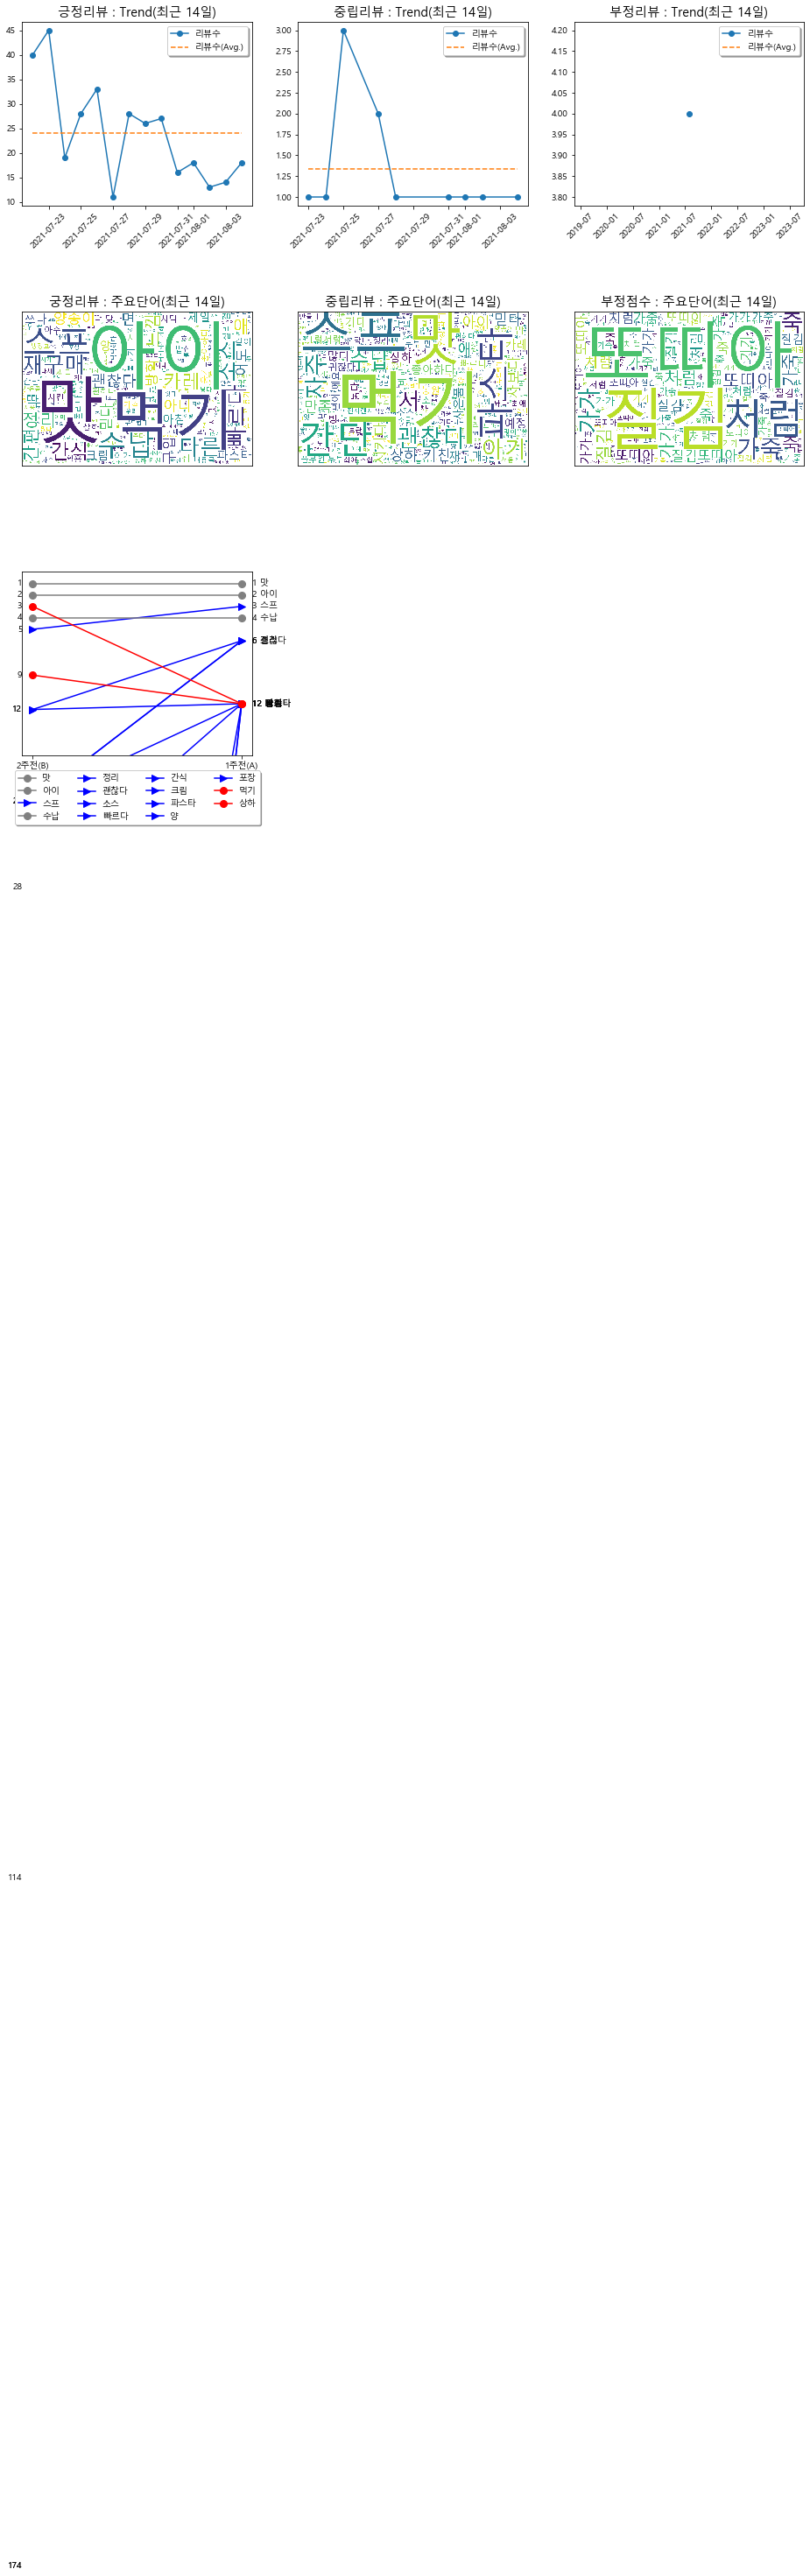

In [687]:
# 그래프 생성
date2 = datetime.today().strftime('%Y%m%d')
image_name = date2[2:] +'_cs_Trend_graph.png'

plt.figure(figsize=(16, 20))

plt.subplot(4,3,1)
average_line(trend_review_pos)
plt.title('긍정리뷰 : Trend(최근 14일)',fontsize='x-large')   

plt.subplot(4,3,2)
average_line(trend_review_nue)
plt.title('중립리뷰 : Trend(최근 14일)',fontsize='x-large')   

plt.subplot(4,3,3)
average_line(trend_review_neg)
plt.title('부정리뷰 : Trend(최근 14일)',fontsize='x-large')   


plt.subplot(4,3,4)
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all[df_review_all['구매자평점'] == '5']['token']), cmap=plt.cm.binary)
plt.title('궁정리뷰 : 주요단어(최근 14일)',fontsize='x-large')

plt.subplot(4,3,5)
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all[df_review_all['구매자평점'] == '4']['token']), cmap=plt.cm.binary)
plt.title('중립리뷰 : 주요단어(최근 14일)',fontsize='x-large')

plt.subplot(4,3,6)
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.imshow(wordcloud_gen(df_review_all[df_review_all['구매자평점'] == '1']['token']), cmap=plt.cm.binary)
plt.title('부정점수 : 주요단어(최근 14일)',fontsize='x-large')

plt.subplot(4,3,7)
REPORT = REPORT_03_pos
dataset = wordrank_pos
word = list(REPORT['내용'].head(15))
arrow_lengths = list(REPORT['diff'].head(15))
for i, v in enumerate(word):
    temp = dataset[dataset['내용'] == v ]
    if arrow_lengths[i] > 0:
        arrow_color = 'red'
        arrow_marker = 'o'
    elif arrow_lengths[i] < 0:
        arrow_color = 'blue'
        arrow_marker = '>'
    else:
        arrow_color = 'gray'
        arrow_marker = 'o'
    plt.plot(temp.기간구분, temp.RANK, color=arrow_color, marker=arrow_marker, markersize=8)
    plt.text(0-0.05, 
             temp.RANK.values[0], 
             '{:,.0f}'.format(temp.RANK.values[0])+' '+ v , va='center' )
    try:
        plt.text(1+0.05, temp.RANK.values[1], '{:,.0f}'.format(temp.RANK.values[1]), va='center', ha='right')
    except:
        pass
yticks = plt.yticks()[0]
plt.ylim(0,16)
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# plt.title('GDP Per Capta\n', loc='left', fontsize=20)
lgd = plt.legend(word, loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, shadow=True, ncol=4)

plt.show()

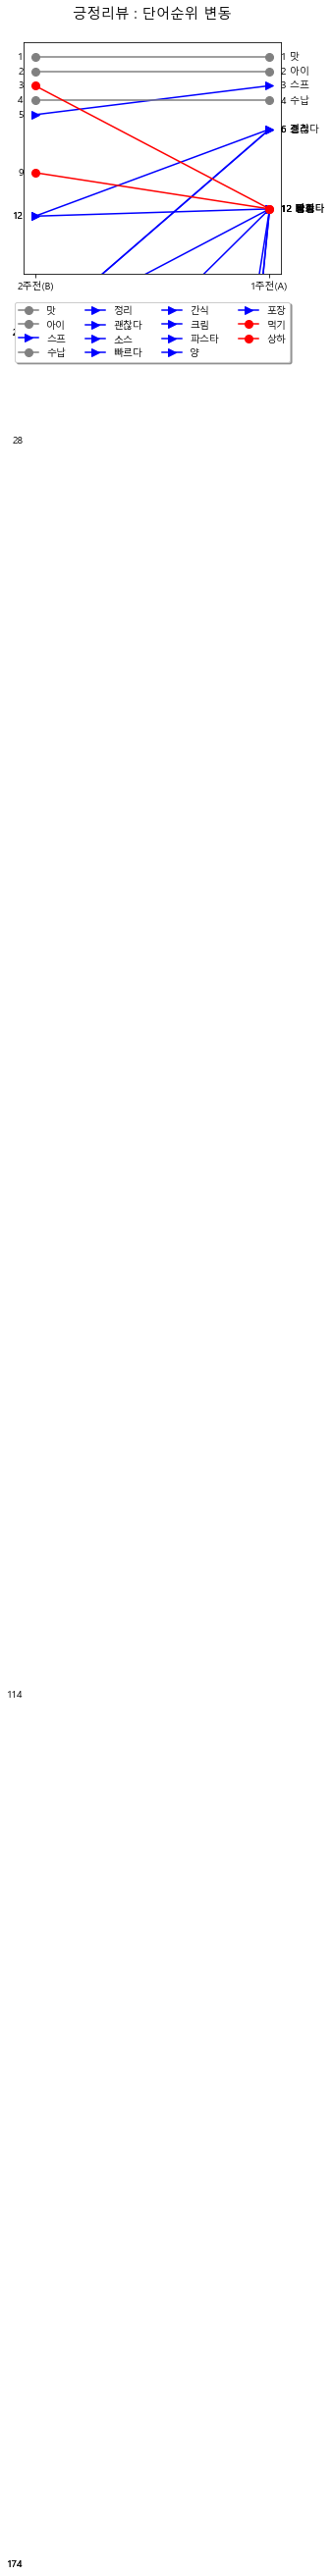

In [703]:
plt.figure(figsize=(16, 20))
plt.subplot(4,3,7)
REPORT = REPORT_03_pos
dataset = wordrank_pos
word = list(REPORT['내용'].head(15))
arrow_lengths = list(REPORT['diff'].head(15))
for i, v in enumerate(word):
    temp = dataset[dataset['내용'] == v ]
    if arrow_lengths[i] > 0:
        arrow_color = 'red'
        arrow_marker = 'o'
    elif arrow_lengths[i] < 0:
        arrow_color = 'blue'
        arrow_marker = '>'
    else:
        arrow_color = 'gray'
        arrow_marker = 'o'
    plt.plot(temp.기간구분, temp.RANK, color=arrow_color, marker=arrow_marker, markersize=8)
    plt.text(0-0.05, 
             temp.RANK.values[0], 
             '{:,.0f}'.format(temp.RANK.values[0])+' '+ v , va='center' )
    try:
        plt.text(1+0.05, temp.RANK.values[1], '{:,.0f}'.format(temp.RANK.values[1]), va='center', ha='right')
    except:
        pass
yticks = plt.yticks()[0]
plt.ylim(0,16)
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.title('긍정리뷰 : 단어순위 변동\n', loc='center', fontsize='x-large')
lgd = plt.legend(word, loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, shadow=True, ncol=4)

plt.show()

In [559]:
###############
# 리포트용 자료 만들기 : 5.키워드별 rawdata
#####

data_by_keyword = pd.DataFrame()

category_count = []
for text1 ,text2 in category :
    df_sort = df_review_all[(df_review_all['token'].str.contains(str(text2)))]
    df_sort = df_sort[(df_sort['category2'].str.contains(str(text1)))][['리뷰등록일','수집채널','리뷰상세내용','구매자평점', 'category2']]
    df_sort = df_sort.drop_duplicates()
    if len(df_sort) > 0:
        df_sort['키워드'] = text2
        category_count.append(len(df_sort))
        data_by_keyword = pd.concat([df_sort, data_by_keyword]) 
    else:
        category_count.append(int(0))
        
report_05 = pd.DataFrame(category)
report_05 = report_05.rename(columns={0: "Category", 1: "키워드"})
report_05['리뷰개수'] = category_count

In [560]:
report_05

,Category,키워드,리뷰개수
0,아몬드브리즈,비리다,3
1,아몬드브리즈,냄새,1
2,아몬드브리즈,맛없다,12
3,아몬드브리즈,밍밍,50
4,두유,비리다,19
5,두유,냄새,2
6,두유,맛없다,13
7,두유,밍밍,37
8,두유,달다,80


In [561]:
data_by_keyword

,리뷰등록일,수집채널,리뷰상세내용,구매자평점,category2,키워드
482,2021-07-22,3 네이버,"자주 먹던건데, 단백질 두유보단 더 달아요",5,두유,달다
485,2021-07-22,3 네이버,다른 제품은 너무 달아서 바꿔봤는데 많이 달지 않고 건강하게 꾸준히 먹을 수 있을 ...,5,두유,달다
512,2021-07-22,3 네이버,맛있어요~ \n완전 달진 않으나 고소한 맛이 👍,5,두유,달다
657,2021-07-22,3 네이버,많이 비리지 않고 적당히 달아서 괜찮았어요!,5,두유,달다
662,2021-07-22,3 네이버,처음먹어보는 고단백 두유인데 생각보다 늦게 하지 않고 적당히 달아요,5,두유,달다
...,...,...,...,...,...,...
7992,2021-08-04,3 네이버,맛있어요 누가맛없다했는데 두유맛임,5,아몬드브리즈,맛없다
1192,2021-07-23,3 네이버,사은품과 같이 배송되었어요\n드라이백만 구입하려해도 몇만원하는데^^\n품질도 좋고 ...,5,아몬드브리즈,냄새
578,2021-07-22,3 네이버,두유에서 비린맛 나서 싫으신분들이면 좋아할꺼같아요 ㅎㅎ 묵직한 느낌은 없고 가벼운느...,5,아몬드브리즈,비리다
5496,2021-07-30,3 네이버,비린내 없고 깔끔한 맛이 너무 좋아요!!,5,아몬드브리즈,비리다


In [603]:
REPORT_04 = pd.concat([df_review_pos.head(10), df_review_neg.head(10)], ignore_index=True)

In [604]:
REPORT_04

,구매자평점,리뷰상세내용,리뷰등록일,수집채널,category2,token,token_attribution
0,5,단백질 양은 이 제품이 최고인듯,2021-07-22,3 네이버,두유,단백질 양은 이 제품 이 최고 인 듯,"[단백질/Noun, 양은/Noun, 이/Noun, 제품/Noun, 이/Josa, 최..."
1,5,고소하이 맛있고 좋아요,2021-07-22,3 네이버,두유,고소 하이 맛있다 좋다,"[고소/Noun, 하이/Noun, 맛있다/Adjective, 좋다/Adjective]"
2,5,맛은 무첨가보다 묵직한 맛이구요. 달달하니 맛있어요.,2021-07-22,3 네이버,두유,맛 은 무 첨가 보다 묵직하다 맛 이구 요 달달 하니 맛있다 어요,"[맛/Noun, 은/Josa, 무/Noun, 첨가/Noun, 보다/Josa, 묵직하..."
3,5,간편한 아침대용입니다,2021-07-22,3 네이버,두유,간편 한 아침 대용 이다,"[간편/Noun, 한/Josa, 아침/Noun, 대용/Noun, 이다/Adjective]"
4,5,가족 다같이 마시고 있어요 재구매했어요,2021-07-22,3 네이버,두유,가족 다 같이 말다 있다 어요 재구매 하다 어요,"[가족/Noun, 다/Adverb, 같이/Josa, 말다/Verb, 있다/Adjec..."
5,5,유통기한도 넉넉하면서 빨대도 예쁘게 같이 잘 왔습니다. 무엇보다 성분이 가장 마음에...,2021-07-22,3 네이버,두유,유통기한 도 넉넉하다 면서 빨대 도 예쁘다 같이 자다 오다 무엇 보다 성분 이 가...,"[유통기한/Noun, 도/Josa, 넉넉하다/Adjective, 면서/Noun, 빨..."
6,5,달지않고 맛있어요\n달지 않은게 점점 익숙해 지내요,2021-07-22,3 네이버,두유,달 지 않다 맛있다 어요 달 지 않다 점점 익숙 해 지내다,"[달/Noun, 지/Josa, 않다/Verb, 맛있다/Adjective, 어요/No..."
7,4,저당이라도 좀달아 별하나뺐어요\n99.98프로짜리가 백배더나아요ㅋ,2021-07-22,3 네이버,두유,저당 이라도 좀달 아 별하나 빼다 어요 프로 짜다 리가 백배 더 나아 요 ㅋ,"[저당/Noun, 이라도/Josa, 좀달/Noun, 아/Josa, 별하나/Noun,..."
8,5,제품 배송 만족해요,2021-07-22,3 네이버,두유,제품 배송 만족 해 요,"[제품/Noun, 배송/Noun, 만족/Noun, 해/Josa, 요/Noun]"
9,5,못막어봤지만 두유 좋아해서 시켰어요,2021-07-22,3 네이버,두유,못 막다 보다 지만 두유 좋다 아해 서 시키다 어요,"[못/VerbPrefix, 막다/Verb, 보다/Verb, 지만/Josa, 두유/N..."


In [ ]:
# 부정 리뷰





In [562]:
##########
# Excel 파일 생성(using XlsxWriter)
###

date2 = datetime.today().strftime('%Y%m%d')
date2 = date2[2:]
excel_name = date2 + '_report.xlsx'
writer = pd.ExcelWriter(excel_name, engine='xlsxwriter')

# 1.키워드별 리뷰내용
data_by_keyword.to_excel(writer, sheet_name='1.키워드기준 리뷰')

# 2.부정리뷰
df_review_neg.to_excel(writer, sheet_name='2.부정리뷰)')

writer.save()

In [654]:
writer.close()

### #.리뷰내용에 대한 T/F 모델 적용(1~5 예측)

In [151]:
data_by_keyword2 = data_by_keyword.reset_index()

In [152]:
len(data_by_keyword2)

218

In [145]:
# 모델 불러오기/활용
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

def sentiment_predict(new_sentence, max_len = 80):
    new_sentence = twitter.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopword] # 불용어 제거
    with open('./model/210729_tokenizer(GRU).pickle', 'rb') as handle:
        tokenizer = pickle.load(handle) # 사전 불러오기
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    loaded_model = tf.keras.models.load_model('./model/210729_NPL_best_model(GRU)_v2.h5')
    score = float(loaded_model.predict(pad_new)) # 예측
    score = round(score/2 * 10,2)
#     print("리뷰점수 {:.2f}".format(score))
    return score

In [157]:
%%time
score_modeling = []
for i in range(len(data_by_keyword2)):
    try:
        score_temp = sentiment_predict(data_by_keyword['리뷰상세내용'][i])
        score_modeling.append(score_temp)
    except:
        score_modeling.append('0')

Wall time: 5min 18s


In [154]:
data_by_keyword2['score_조정'] = score_modeling

In [155]:
data_by_keyword2

,level_0,index,리뷰등록일,수집채널,리뷰상세내용,구매자평점,category2,키워드,score_조정
0,0,160,2021-07-15,3 네이버,달지않은 두유먹다가 주문했는데 생각보다 많이 달아요.,4,두유,달다,2
1,1,162,2021-07-15,3 네이버,유통기한도 적당하고 맛도 좋네요\n쵸코우유보다 덜 달아요,4,두유,달다,5
2,2,165,2021-07-15,3 네이버,이거 먹으니 다른건 못 먹겠어요ㅋㅋㅋ 너무 맛있어요\n초코우유에 비해 덜 달아서 좋아요,5,두유,달다,2
3,3,178,2021-07-15,3 네이버,포장은 이 상태에서 딱 맞는 박스에 담겨 옵니다. 항상 먹는 제품이라 잘 먹고 있습...,5,두유,달다,5
4,4,194,2021-07-15,3 네이버,성분 좋고 안 달아서 먹기 좋아요!,4,두유,달다,1
...,...,...,...,...,...,...,...,...,...
213,213,8067,2021-07-28,3 네이버,처음에 먹을때는 단맛에 길들여져있어서 맛없었는데 지금은 먹을만하네요ㅋ,5,아몬드브리즈,맛없다,1
214,214,8528,2021-07-28,3 네이버,역시 아몬드브리즈~~~맛없는라인이없어요~^^\n이번에 식이섬유 나왔길래 가격도착하고...,5,아몬드브리즈,맛없다,0
215,215,3680,2021-07-21,3 네이버,처음에는 냄새가 익숙하지 않았는데 먹을수록 가볍고 맛있어요. 냉장고에 떨어지지 않게...,5,아몬드브리즈,냄새,4
216,216,5401,2021-07-23,3 네이버,사은품과 같이 배송되었어요\n드라이백만 구입하려해도 몇만원하는데^^\n품질도 좋고 ...,5,아몬드브리즈,냄새,0


In [156]:
# Excel 저장
date2 = datetime.today().strftime('%Y%m%d')
excel_name = date2[2:] +'_' +category_group +'_report.xlsx'
data_by_keyword2.to_excel(excel_name, sheet_name= 'Sheet1' )